## Brier Score

The Brier Score measures the fit of the probability estimates of the observed data. It is given by the average squared difference of the true label and the predicted probability.

Brier Score = mean( (y -pred)^2 )

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# toy data
from sklearn.datasets import make_classification

# various models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    brier_score_loss,
    roc_auc_score,
    plot_roc_curve,
)

from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings("ignore")

## Function to create toy data

In [2]:
def create_dataset(weights):

    # returns arrays
    X, y = make_classification(
        n_samples=10000,
        n_features=20,
        n_informative=2,
        n_redundant=10,
        n_clusters_per_class=1,
        weights=[weights],  # to balance (or not) the classes
        class_sep=1,  # how separated the classes are
        random_state=1)

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X)
    y = pd.Series(y)

    return X, y

## Create a balanced dataset

The 2 classes are fairly well separated for the demonstration.

In [3]:
X, y = create_dataset(weights=0.5)

# show dataset
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.367744,0.169118,0.490309,-0.099269,-0.321689,2.028729,-1.217080,1.052782,-0.219787,-0.532625,-0.284029,0.748649,-1.609348,-0.604958,-0.562323,0.781532,0.972701,1.099992,0.386859,0.932917
1,-0.992571,1.453483,1.240380,-0.258057,-0.354514,-0.936577,0.813220,1.180121,0.123450,-1.598957,-1.581506,1.981644,0.457818,0.116732,-1.117829,-0.350214,1.469932,1.829999,-0.422171,-0.895785
2,0.777302,1.651992,1.284101,-1.147468,-0.541526,-0.648523,-0.506134,1.008741,-0.006846,-1.691435,-1.761168,2.064089,-0.597753,0.357367,-1.113473,-0.696747,1.379473,1.757694,-0.638204,-0.524468
3,0.503518,-0.010875,0.213944,0.064097,0.823696,-0.104237,-0.844305,0.581817,0.907700,-0.211645,-0.052696,0.319429,-1.281878,-0.399945,-0.270524,0.533142,0.506226,0.558628,0.284446,-2.104917
4,0.030649,-0.176175,-0.067561,-0.116144,-1.406837,-0.660697,-0.093624,0.076004,-0.876487,0.110881,0.167762,-0.116232,-0.303181,-0.162147,0.032064,0.239197,0.013647,-0.009563,0.155488,0.685216


In [4]:
# number of observations per class

y.value_counts()

1    5002
0    4998
dtype: int64

In [5]:
# balancing ratio

y.value_counts() / len(y)

1    0.5002
0    0.4998
dtype: float64

### Separate into train and test sets

In [6]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 20), (3000, 20))

In [7]:
# balancing ratio: train set

y_train.value_counts() / len(X_train)

0    0.503857
1    0.496143
dtype: float64

In [8]:
# number of observations per class

y_train.value_counts()

0    3527
1    3473
dtype: int64

You can go ahead and check the balancing ratio for the test set, should be similar.

## Set up models

In [9]:
# Logistic Regression

logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)


# naive Bayes
bayes = GaussianNB().fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=0,
).fit(X_train, y_train)

# Gradient Boosting
gm = GradientBoostingClassifier(
    n_estimators=10,
    random_state=0,
).fit(X_train, y_train)

## ROC-AUC

In [10]:
for model in [logit, bayes, rf, gm]:
    
    # obtain predictions
    probs = model.predict_proba(X_test)[:, 1]
    
    # print roc-auc
    print('roc-auc of ', type(model).__name__, roc_auc_score(y_test, probs))

roc-auc of  LogisticRegression 0.9504988308963483
roc-auc of  GaussianNB 0.9369099739058022
roc-auc of  RandomForestClassifier 0.9476179763191486
roc-auc of  GradientBoostingClassifier 0.960202457896485


All models seem to have a good fit.

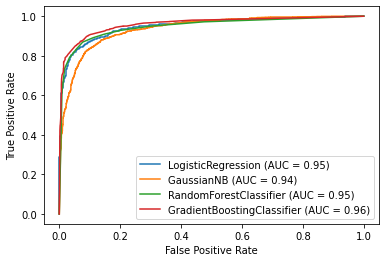

In [11]:
ax = plt.gca()

for model in [logit, bayes, rf, gm]:
    
    # plot ROC curve
    tmp_disp = plot_roc_curve(model, X_test, y_test, ax=ax)        

The Gradient Boosting Classifier seems to perform slightly better than Random Forests and Logistic Regression, and Naive Bayes has a tiny worse performance.

## Brier Score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

In [12]:
for model in [logit, bayes, rf, gm]:

    # obtain predictions
    probs = model.predict_proba(X_test)[:, 1]

    # print roc-auc
    print('Brier Score of ', type(model).__name__,
          brier_score_loss(y_test, probs))

Brier Score of  LogisticRegression 0.08377581814025406
Brier Score of  GaussianNB 0.12107014478789326
Brier Score of  RandomForestClassifier 0.08203
Brier Score of  GradientBoostingClassifier 0.0955528705367653


From the Brier Score, we see that even though Gradient Boosting Machines show the highest performance, it Brier Score is bigger, suggesting that its probabilities are not as well calibrated as those from Random Forest and Logistic Regression.

## Calibration Curves

In [13]:
# we learned this in the previous notebook

def plot_calibration_curve(bins):

    plt.figure(figsize=(10, 8))

    for model in [logit, bayes, rf, gm]:

        # obtain predictions
        probs = model.predict_proba(X_test)[:, 1]

        # obtain calibration curve parameters
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, probs, n_bins=bins, strategy='uniform')

        plt.plot(mean_predicted_value, fraction_of_positives,
                 label=type(model).__name__)

    # add perfectly calibrated predictions
    plt.plot(np.linspace(0, 1, bins), np.linspace(0, 1, bins),
             linestyle='--', color='red', label='Perfect calibration')

    # add labels
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')

    # show
    plt.show()

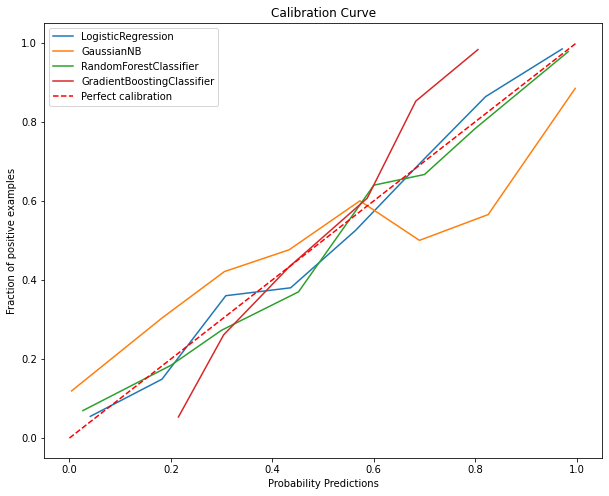

In [14]:
plot_calibration_curve(bins=8)

As expected, Naive Bayes and Gradient Boosting Machines show the worse calibration.

**HOMEWORK**: 

Change the following parameters:

- number of observations in the dataset

- balancing ratio

- number of predictive features

and determine the change in Brier Score, ROC and calibration curves.

What do you see?

## Imbalanced dataset

In [15]:
# create imbalanced dataset
X, y = create_dataset(weights=0.9)

# number of observations per class
y.value_counts()

0    8952
1    1048
dtype: int64

In [16]:
# balancing ratio

y.value_counts() / len(y)

0    0.8952
1    0.1048
dtype: float64

### Separate train and test

In [17]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 20), (3000, 20))

### Set up models

In [18]:
# Logistic Regression on balanced dataset

logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)


# naive Bayes
bayes = GaussianNB().fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=10, random_state=0).fit(X_train, y_train)

# Gradient Boosting
gm = GradientBoostingClassifier(
    n_estimators=10, random_state=0).fit(X_train, y_train)

## ROC-AUC

In [19]:
for model in [logit, bayes, rf, gm]:

    # obtain predictions
    probs = model.predict_proba(X_test)[:, 1]

    # print roc-auc
    print('roc-auc of ', type(model).__name__, roc_auc_score(y_test, probs))

roc-auc of  LogisticRegression 0.9192685694606704
roc-auc of  GaussianNB 0.9085849339753839
roc-auc of  RandomForestClassifier 0.8917101828456772
roc-auc of  GradientBoostingClassifier 0.9133225873183471


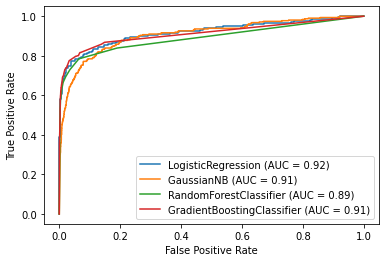

In [20]:
ax = plt.gca()

for model in [logit, bayes, rf, gm]:
    
    # plot ROC curve
    tmp_disp = plot_roc_curve(model, X_test, y_test, ax=ax)    

All models seem to have roughly the same performance.

## Brier Score

In [21]:
for model in [logit, bayes, rf, gm]:

    # obtain predictions
    probs = model.predict_proba(X_test)[:, 1]

    # print roc-auc
    print('Brier Score of ', type(model).__name__,
          brier_score_loss(y_test, probs))

Brier Score of  LogisticRegression 0.0383281176788733
Brier Score of  GaussianNB 0.11156648168896698
Brier Score of  RandomForestClassifier 0.03984666666666667
Brier Score of  GradientBoostingClassifier 0.041962591579426944


See that the Brier Score values are small, that represents more the data imbalance than the calibration of the probabilities, as we will see:

## Calibration Curve

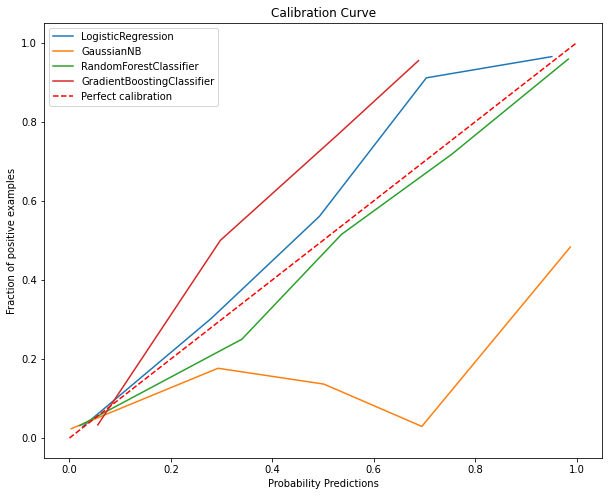

In [22]:
plot_calibration_curve(bins=5)

We see that the models return not so well calibrated probabilities, apart from Random Forests. Remember however, that there are very few observations of the minority class (towards the right of the plot), to determine accurately the fraction of positives. So this calibration curve could be inaccurate.


**HOMEWORK**

Go ahead and change:

- the class separability

- the number of observations in the dataset (the most interesting one)

- the number of predictive features

- the model (make models that perform worse or better than those in this notebook)

and evaluate how these affect the brier score and calibration curves of the different models